<a href="https://colab.research.google.com/github/yutronax/model_train/blob/main/best_model_chosen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Hedef değişken (MEDV) ile en yüksek korelasyona sahip değişkenler:
MEDV       1.000000
RM         0.723951
ZN         0.406822
B          0.347256
DIS        0.279547
CHAS       0.173701
CRIM      -0.397230
AGE       -0.407470
RAD       -0.416638
NOX       -0.459054
TAX       -0.508864
INDUS     -0.510829
PTRATIO   -0.543809
LSTAT     -0.743450
Name: MEDV, dtype: float64
Kalan değişkenler: Index(['ZN', 'CHAS', 'RM', 'DIS', 'B', 'MEDV'], dtype='object')


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


En iyi model: GradientBoostingRegressor ({'subsample': 0.5, 'n_estimators': 50, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 3, 'learning_rate': 0.1})


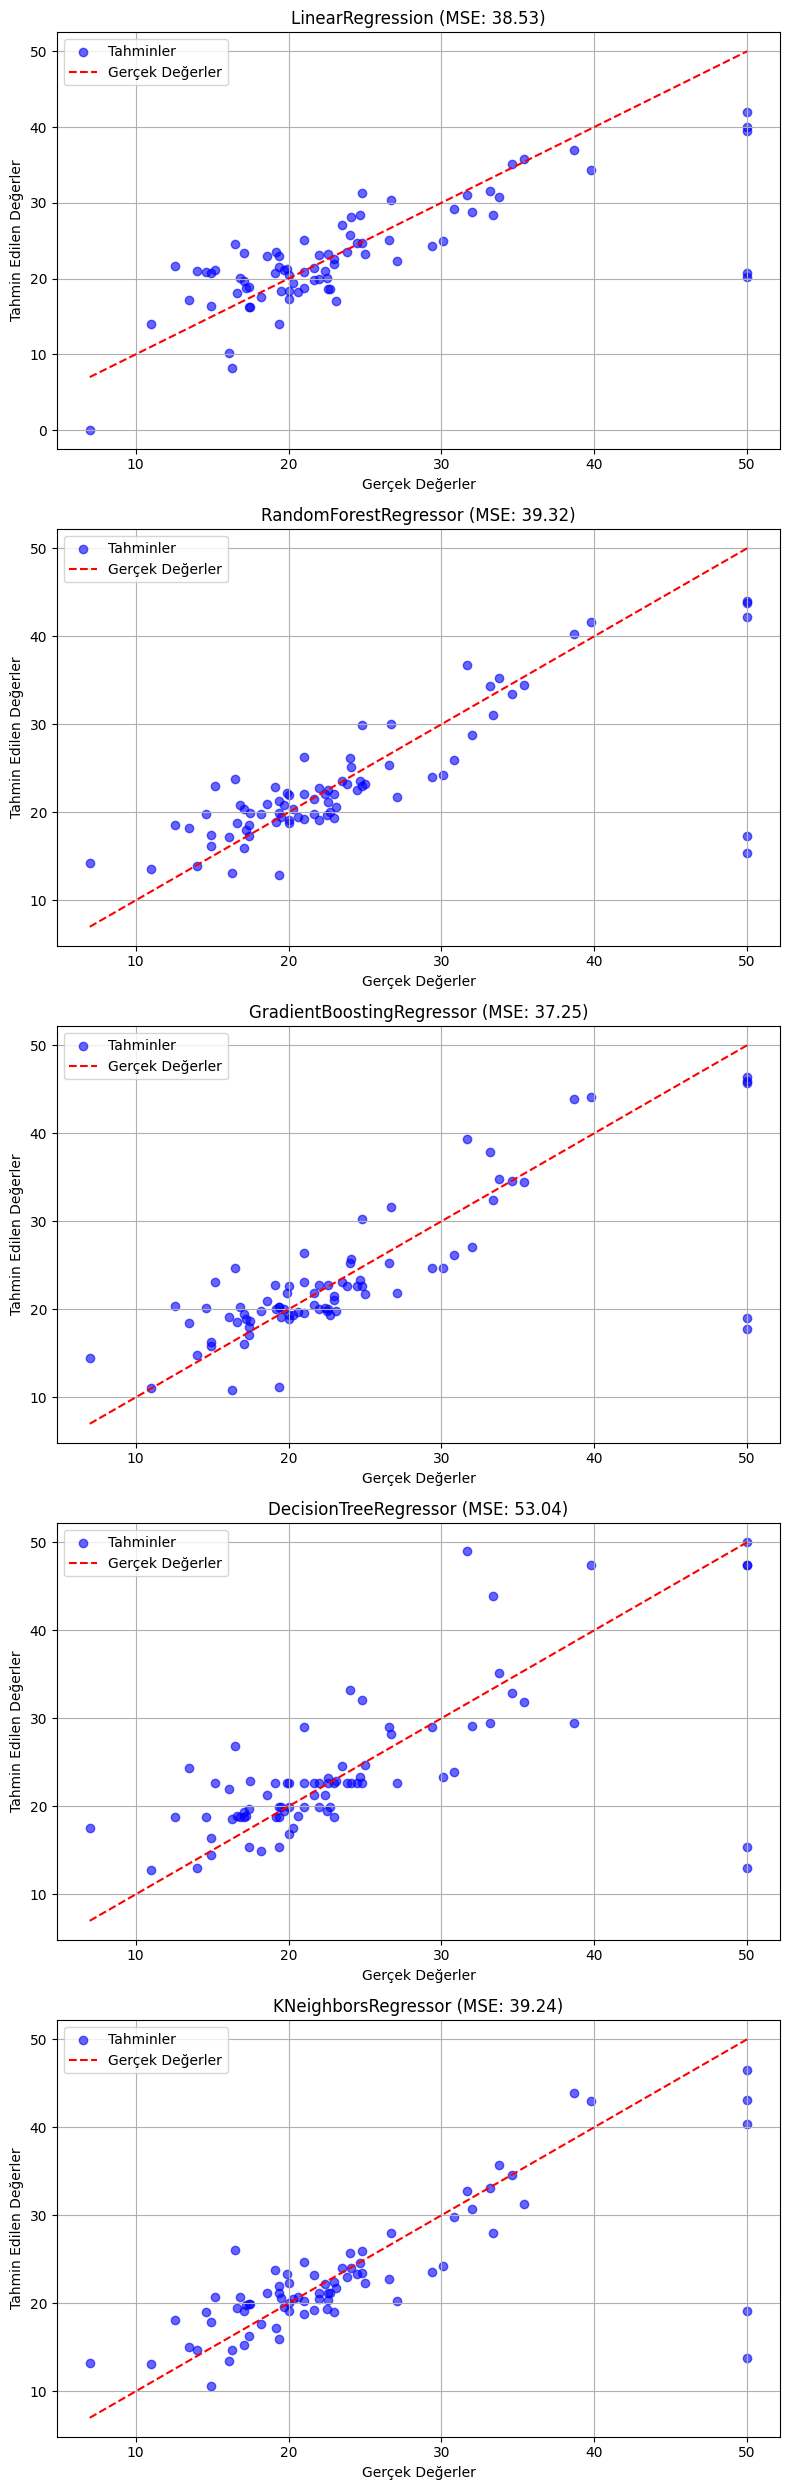

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as meaner

# %% [markdown]
# ## 1. Veri Setini Yükleme ve Temizleme
# Öncelikle veri setini yüklüyoruz ve eksik verileri temizleyerek analiz için hazır hale getiriyoruz.

data = pd.read_csv("HousingData.csv")
data = data.dropna()
corr_matrix = data.corr()

# %% [markdown]
# ## 2. Korelasyon Analizi
# Hedef değişkenimiz MEDV ile en yüksek korelasyona sahip değişkenleri belirleyerek gereksiz olanları çıkartıyoruz.

target_corr = corr_matrix["MEDV"].sort_values(ascending=False)
print("\nHedef değişken (MEDV) ile en yüksek korelasyona sahip değişkenler:")
print(target_corr)

for i in range(len(target_corr)):
    if target_corr.iloc[i] < 0:
        data = data.drop(target_corr.index[i], axis=1)
print("Kalan değişkenler:", data.columns)

# %% [markdown]
# ## 3. Bağımsız ve Bağımlı Değişkenleri Belirleme
# MEDV hedef değişkenimizdir. Modeli eğitmek için bağımsız değişkenleri belirliyoruz.

X = data.drop("MEDV", axis=1)
y = data["MEDV"]

# %% [markdown]
# ## 4. Model Seçimi ve Hiperparametre Optimizasyonu
# Çeşitli regresyon modellerini ve en uygun hiperparametreleri belirlemek için RandomizedSearchCV kullanıyoruz.

models = [
    [LinearRegression(), {}],
    [RandomForestRegressor(), {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ["sqrt", "log2"]
    }],
    [GradientBoostingRegressor(), {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'subsample': [0.5, 0.75, 1.0]
    }],
    [DecisionTreeRegressor(), {
        'criterion': ["squared_error", "friedman_mse"],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ["sqrt", "log2"]
    }],
    [KNeighborsRegressor(), {
        'n_neighbors': [3, 5, 7],
        'weights': ["uniform", "distance"],
        'algorithm': ["auto", "ball_tree", "kd_tree", "brute"]
    }]
]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

fig, axes = plt.subplots(nrows=len(models), ncols=1, figsize=(8, 5 * len(models)))

best_models = []

for i, (model, params) in enumerate(models):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    grid_search = RandomizedSearchCV(model, params, cv=5, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train_scaled, y_train)
    y_pred = grid_search.predict(X_test_scaled)

    mse = meaner(y_test, y_pred)
    best_models.append({"model_name": model.__class__.__name__, "model_params": grid_search.best_params_,
                        "MSE": mse, "train_score": grid_search.score(X_train_scaled, y_train)})

    ax = axes[i]
    ax.scatter(y_test, y_pred, alpha=0.6, color="blue", label="Tahminler")
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red', label="Gerçek Değerler")
    ax.set_title(f"{model.__class__.__name__} (MSE: {mse:.2f})")
    ax.set_xlabel("Gerçek Değerler")
    ax.set_ylabel("Tahmin Edilen Değerler")
    ax.legend()
    ax.grid()

# %% [markdown]
# ## 5. En İyi Modelin Seçimi ve Sonuçlar
# En düşük hata değerine sahip modeli belirliyoruz ve sonuçları özetliyoruz.

best_model = min(best_models, key=lambda x: x["MSE"])
print(f"En iyi model: {best_model['model_name']} ({best_model['model_params']})")

plt.tight_layout()
plt.show()

# %% [markdown]
# ## 6. Sonuç
# En iyi modelimizi belirledik ve performansını değerlendirdik. Bu model ile gelecekte yeni veri üzerinde tahminler yapabiliriz.
